# An Introduction to Data Science through League of Legends
### by: Faraz Karim, Sky Cen, Devin Moon
---
[League of Legends](https://www.leagueoflegends.com/en-us/) is a Multiplayer Online Battle Arena (MOBA) that was developed and released by Riot Games in 2009. The standard gamemode consists of two teams, five players on each team, that fight to destroy the other team's nexus (base). Each player controls a champion (character) which each have their own unique sets of abilities. Along the way, team's can fight neutral objectives to gain powerups and other rewards in order to make their champions stronger as the game progresses.
 
There may be many terms that are not familiar to those who have not played League of Legends. We have provided a list of terms with their definitions in order to make the tutorial more clear.
 
- Summoner: A player that is playing the game and controlling their character i.e player
- Champion: The character that a player can control. There are many different champions in the game with many different abilities.
- KDA: Kill Death Assists or KDA for short in the ratio of a participant's Kills and Assists per Death they have. (Kills + Assists) / Deaths
- Ward: An item that provides vision to a certain portion of the map. The item can be synonymous to a "torch" that provides light in a dark area.

By following along with our tutorial, we hope that those new to data science can gain a basic understanding of how data science can be conducted using tools such as various Python libraries.

## Getting the Data

In [1]:
import requests
import json
import re
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt

## Data Collection / Curation
We start the data collection and data science as a whole by importing the various Python libraries needed for the analysis.

In [2]:
API_KEY = 'RGAPI-35e4330e-5309-4cad-ac33-60420e6bddb5'
FEATURED_GAMES_URL = f'https://na1.api.riotgames.com/lol/spectator/v4/featured-games?api_key={API_KEY}'
SUMMONER_INFO_URL = 'https://na1.api.riotgames.com/lol/summoner/v4/summoners/by-name/'
MATCH_ID_URL = 'https://americas.api.riotgames.com/lol/match/v5/matches/by-puuid/'
MATCH_INFO_URL = 'https://americas.api.riotgames.com/lol/match/v5/matches/'

The constants above represent much of the information needed to call the API endpoints Riot provides. The `API_KEY` is a string that must be added onto the end of every API endpoint in order for Riot to authenticate the request. Without the `API_KEY`, no request will be able to bring in information as Riot will block any requests with it. For Riot's specific API, the `API_KEY` resets every 24 hours and must be reknewed from the user's dashboard when it expires. The dashboard can be accessed at [Riot's Developer API Dashboard.](https://developer.riotgames.com)

The next four constants represent the different API endpoints that will be used for the project. The documentation page for each API can be accessed by clicking on the constant's name found in the list below.
<ul>
    <li>
        <a href="https://developer.riotgames.com/apis#spectator-v4/GET_getFeaturedGames">FEATURED_GAMES_URL</a>: The API endpoint provides a list of recently played featured games. The endpoint will be used to get a list of random users to pull match data from.
    </li>
    <li>
        <a href="https://developer.riotgames.com/apis#summoner-v4/GET_getBySummonerName">SUMMONER_INFO_URL</a>: Given a summoner's (player's) in-game username, the API endpoint can be used to get the players PUUID (universally unique identifer). The player's PUUID can then be used to find more match information later.
    </li>
    <li>
        <a href="https://developer.riotgames.com/apis#match-v5/GET_getMatchIdsByPUUID">MATCH_ID_URL</a>: Using a player's PUUID, the player's recent match history can be obtained using this API endpoint.
    </li>
    <li>
        <a href="https://developer.riotgames.com/apis#match-v5/GET_getMatch">MATCH_INFO_URL</a>: By supplying a `match_id` to the API endpoint, a long list of detailed statistics and information for the given match can be acquired.
    </li>
</ul>

In [3]:
# # getting a list of currently featured games.

# games_req = requests.get(FEATURED_GAMES_URL).text
# all_games = json.loads(games_req)


# # gathering names of all players in each featured game
# players = []
# for game in all_games['gameList']:
#     for particpant in game['participants']:
#         players.append(particpant['summonerName'])


# # gathering the encrypted puuids of each summoner and then finding the match_ids of their first 20 recent matches.

# match_ids = []
# for player in players:
#     url = f'{SUMMONER_INFO_URL}{players}?api_key={API_KEY}'
#     player_req = requests.get(url).text
#     player_info = json.loads(player_req)

#     COUNT = 20
#     url = f'{MATCH_ID_URL}{player_info["puuid"]}/ids?start=0&count={COUNT}&api_key={API_KEY}'
#     match_ids_req = requests.get(url).text
#     matches = json.loads(match_ids_req)

#     match_ids += matches


## saving the gathered match IDs into a text file.

# with open("saved-match-ids.txt", "a") as OUTPUT_FILE:
#     print(match_ids, file=OUTPUT_FILE)


The code above goes through the process of accessing and collecting the data directly from Riot's APIs. In order to get a large amount of random data, we first used one of Riots API endpoints to get a list of featured games that have been played recently. The API request returns a large string that can be then parsed into a JSON object. Within the object is a `gameList` field which provides a list of the featured games. Within the `gameList` list, a `participants` field can be accessed which gives a list of participant usernames for a particular game in the list.

Using the `gameList`, all of the participants in each game can be stored within the `players` list. Since the featured games API endpoint only provides a small amount of games, we can instead use the recently played matches for each of the participants we stored allowing us to access many more matches that we could not get before.

Going through each player in the `players` list, we then need to call another API endpoint using each player's username. The way Riot's API works is that it is not possible to access individual player data through their username alone. Riot instead provides an option to acquire the PUUID, a universally unique identifer, that can then be used to access more information about each player. So, each player's username is used with an API endpoint to get their PUUID. Afterwards, their PUUID is used with another API endpoint to get the player's recent 20 matches that they have played. These matches come back as match IDS (ex: NA1_4301320954) which can then be used with another API endpoint to get more information about the particular match.

As seen through this process, data collection may sometimes not be a straightforward step. Some companies may provide many API endpoints but multiple API endpoints may need to be used in order to jump through the data and collect exactly what data you are looking for.

The code is commented as to not alter the data currently saved in the text files of the project. Feel free to run the code yourself if you want to get new data to test for yourselves!

In [4]:
matches = []

with open('saved-match-ids.txt') as file:
    text = file.readlines()
    pattern = r"NA1_\d{10}"

    matches = re.findall(pattern, text[0])

with open('saved-match-data.txt') as file:
    text = file.readlines()
    pattern = r"NA1_\d{10}"

    matches += re.findall(pattern, text[0]) 

matches = list(set(matches))

After storing all of the match IDs into text files, we created a small script to go through each text file and store all of the match ids into one single list: `matches`.

## Data Management

In [5]:
kda = []
win = []
vision = []
participant_match_id = []
game_mode = []
team_dragons = []

# Iterate through all of the match IDs stored in matches.
for match in matches:
    url = f'{MATCH_INFO_URL}{match}?api_key={API_KEY}'
    match_info_req = requests.get(url)

    # Check to see if the API response contains a 'text' field and an 'info' field within the 'text' field.
    if hasattr(match_info_req, 'text') and 'info' in match_info_req.text:
        info = json.loads(match_info_req.text)['info']
        teams = info['teams']

        # Iterate through each participant in the current match.
        for participant in info['participants']:
            # Check if the 'challenges' field is present for the current player.
            if 'challenges' in participant:
                participant_match_id.append(match)
                kda.append(participant['challenges']['kda'])
                game_mode.append(info['gameMode'])
                win.append(participant['win'])
                vision.append(participant['challenges']['visionScorePerMinute'])

                # Gather the total team dragon kills for the current player's team
                currTeam = participant['teamId']
                for team in teams:
                    if team['teamId'] == currTeam:
                        team_dragons.append(team['objectives']['dragon']['kills'])


Going through each match id in `matches`, we are then able to call another API endpoint from Riot in order to get a much more detailed overview of each match. After calling the API request, the data given back sometimes can have missing or unexpected values. For instance, the API is supposed to return a string of a JSON object with the field `info` containing the information of each game. However, we found that some calls the the API endpoint did not return an `info` field. In order to combat this issue, we simply checked to make sure the call returned an `info` field as any match without its info would be useless to us.

For those objects which did include an `info` field, a great amount of data was able to be extracted for each match. Particularly, the `info` object contained another object labeled as `participants`. The `participants` object contains a big object with many actions and statistics for each player in the match. In addition, the `participants` object containined a `challenges` object which provided even more statistics for a particular player.

In addition to the 'participants' object, there was also a `teams` object in the `info` field which contained information that pertained to an entire team in the match. In order to simplify our analysis, we stuck with six fields that we wanted to collect for each participant:
    <ol>
        <li>
            `match_id` (string): The same match ID code that was used to call the API endpoint. The match ID will be stored for each participant in order to keep track of which participants participated in the same matches.</li>
        <li>
            `kda` (float): Kill Death Assists or KDA for short in the ratio of a participant's Kills and Assists per Death they have. (Kills + Assists) / Deaths
        </li>
        <li>
            `game_mode` (string): In League of Legends, there are multiple game modes that a player could player. For this project we stuck with the most popular gamdemode, "CLASSIC".</li>
        <li>
            `win` (boolean): If they player won a given match, the variable is set to `True`. Otherwise, if the player lost, the variable is set to `False`.</li>
        <li>
            `vision` (double): In the CLASSIC mode of League of Legends, each player can see a small area of the map that they or their teammates are in. Otherwise, the map is hidden and the player cannot see any enemies within those regions. To combat the issue, players are given the ability to place "wards" which act as torches that can illuminate a certain area of a map for a certain period of time for them and their teammates. `vision` numerically tracks the effectiveness of a player's ability to give their team vision by giving them a point for each ward they provide and how long these wards last, and other metrics such as how many wards that they destroy from the other team. This score is divided by the total duration of the game becoming vision score per minute.
        </li>
        <li>
            `team_dragons` (integer): In the CLASSIC mode of League of Legends, some monsters found in the map are called "neutral objectives". These monsters belong to neither team and can be killed by anybody in order to get their teams various rewards. Dragons, in particular, are a big neutral objective that gives teams very powerful powerups. The variables keeps track of how many dragons a player's team has killed within a match.
        </li>
    </ol>
Similarly to the issues found with the inital API call to get the match info, each match sometimes did not contain a `participants` field or `challenges` field. Any match without these two fields were also skipped as the data would not be useful to us for this anlysis.

As seen in previous data collection sections, large APIs can provide a great deal of information, but there are many hurdles that need to be overcome. Missing and unepected data is one hurdle, and large API outputs provide a unique hurdle in that there may be many nested objects that need to be traversed to find the data that you want.

In [6]:
df = pd.DataFrame()

df['match_id'] = participant_match_id
df['kda'] = kda
df['vision'] = vision
df['win'] = win
df['game_mode'] = game_mode
df['team_dragons'] = team_dragons

# Filtering out game modes that are not CLASSIC
df = df[df['game_mode'] == 'CLASSIC']
df = df.reset_index()
df = df.drop(labels='index', axis=1)

df

,match_id,kda,vision,win,game_mode,team_dragons
0,NA1_4301292947,2.714286,0.822167,True,CLASSIC,4
1,NA1_4301292947,7.333333,0.483610,True,CLASSIC,4
2,NA1_4301292947,1.625000,0.045843,True,CLASSIC,4
3,NA1_4301292947,5.600000,0.637744,True,CLASSIC,4
4,NA1_4301292947,2.428571,2.253136,True,CLASSIC,4
...,...,...,...,...,...,...
2570,NA1_4301313036,1.000000,1.023878,True,CLASSIC,5
2571,NA1_4301313036,3.555556,0.847781,True,CLASSIC,5
2572,NA1_4301313036,2.384615,1.170984,True,CLASSIC,5
2573,NA1_4301313036,2.750000,0.410201,True,CLASSIC,5


Using the lists collected in the previous cells, we are now able to create a Pandas DataFrame. The DataFrame will be filled with rows that correspond to a single player in a particular match. In addition, we also decided to drop any rows that do not take place in the "CLASSIC" game mode as any game not played in the "CLASSIC" mode will have many missing data points witch would not be useful to us in further analysis.

## Exploratory Data Analysis

### Vision vs KDA

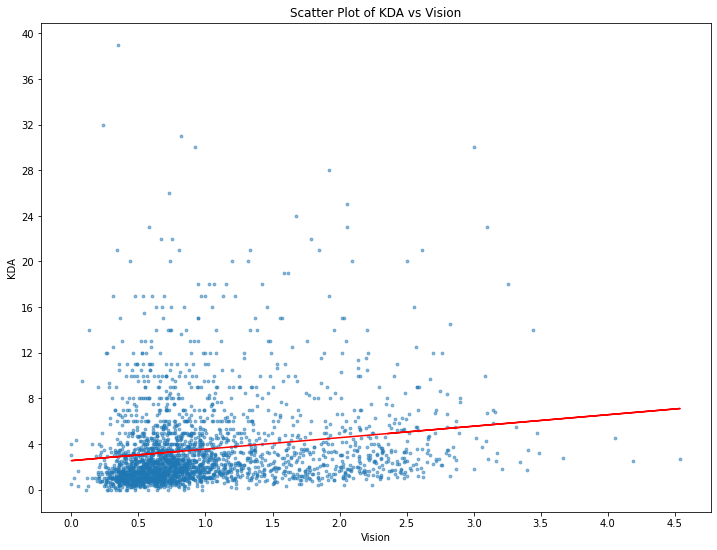

In [7]:
# Vision vs KDA Scatter Plot
plt.figure(figsize=(12,9))
plt.scatter(df.vision, df.kda, s = 8, alpha = 0.5)
plt.title("Scatter Plot of KDA vs Vision")
plt.ylabel("KDA")
plt.xlabel("Vision")
plt.yticks(np.arange(0, 41, 4))
plt.xticks(np.arange(0, 5.5, 0.5))

fit = np.polyfit(df.vision, df.kda, deg = 1 )
plt.plot(df.vision, fit[0] * df.vision + fit[1], color='red')

plt.show()

This first scatterplot compares Vision and KDA. We can see that the vast majority of data points are located in the bottom left, with KDA ratio's between 0 and 6, and vision scores between 0 and 1.5. It makes sense that KDA ratio's are very condensed in this range because games are ranked, so it is pretty difficult to have acquire many kills and assists. We can assume that the vast number of outliers come from "smurfs", a term used to describe high-ranked players who create new accounts to play against worse opponents. By playing against opponents much less skilled than them, they are able to easily rack up kills and assists while minimzing deaths, leading to so many outliers in the data.

From the regression line, we can see that there is a slight trend between vision and a player's KDA. As vision increases, KDA also increases. This can be explained from the fact that more vision on the map gives a player more knowledge about where the enemies are located. This allows them to avoid death as they know where the enemies are. Additionally, knowing the enemies' locations and removing the enemies' vision allows a player to have more opportunity to kill the enemies, increasing KDA, by setting up ambushes. 

### Vision vs Team Dragon Kills

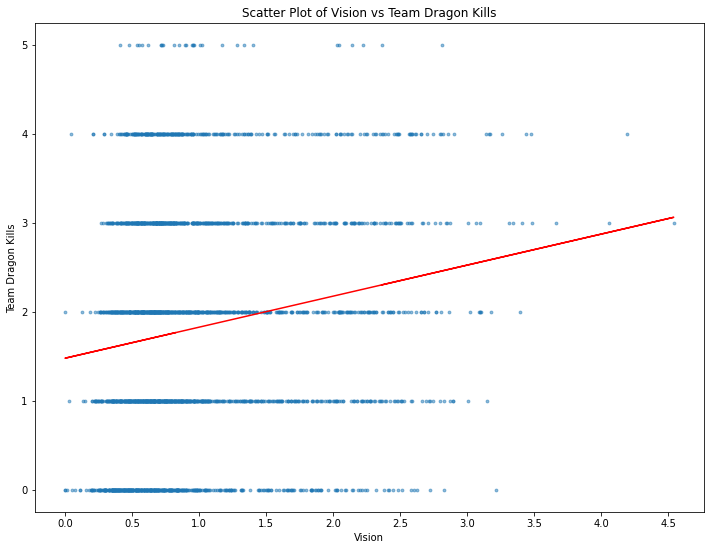

In [8]:
plt.figure(figsize=(12,9))
plt.scatter(df.vision, df.team_dragons, s = 8, alpha = 0.5)
plt.title("Scatter Plot of Vision vs Team Dragon Kills")
plt.xlabel("Vision")
plt.ylabel("Team Dragon Kills")
plt.yticks(np.arange(0, 6, 1))
plt.xticks(np.arange(0, 5.5, 0.5))

fit = np.polyfit(df.vision, df.team_dragons, deg = 1 )
plt.plot(df.vision, fit[0] * df.vision + fit[1], color='red')

plt.show()

From this violin plot of vision vs team dragon kills, we can note that vision seems to remain fairly constant based on the number of dragon kills. The regression line indicates that there is some correlation between vision and the number of dragon's a team kills. This makes sense because in order to successfully secure neutral objectives, such as the dragon, a team must have proper vision control around the neutral objective. This means that they should have ample vision and deny as much of the opponent's vision around the objective.

We've looked at how some statistics affect eachother, now let's look at how these factors affect win/loss.

### Vision vs Win/Loss

Text(0.5, 1.0, 'Box Plot of Vision and Win/Loss')

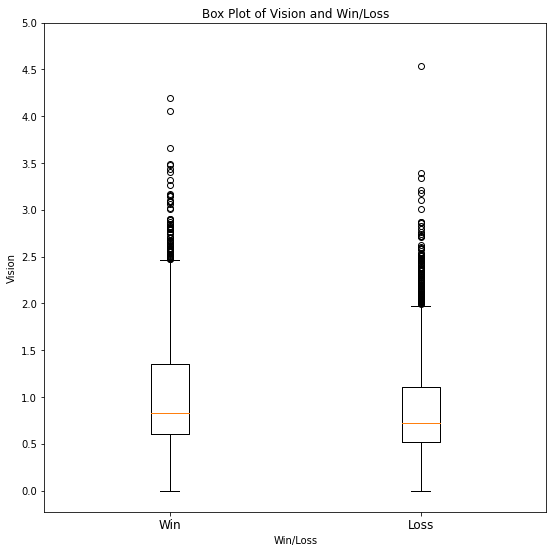

In [9]:
vision_win = []
vision_lose = []

for c, col in df.iterrows():
    if col['win'] == True:
        vision_win.append(col['vision'])
    else:
        vision_lose.append(col['vision'])
        
fig, ax = plt.subplots(figsize = (9,9))

ax.boxplot(x = [vision_win, vision_lose])
ax.set_xlabel("Win/Loss")
ax.set_xticks([1,2], labels = ['Win', 'Loss'])
ax.set_xticklabels(['Win', 'Loss'], fontsize=12)
ax.set_yticks(np.arange(0, 5.5, .5))
ax.set_ylabel("Vision")
ax.set_title("Box Plot of Vision and Win/Loss")

This box plot examines the relation between a player's vision score and whether they win or lose. Regardless of whether they won or lost, players tend to have similar vision scores. This could be explained by the fact that players may not prioritize vision in their games. Players may think that getting vision is not worth their time, and instead focus on kills. Another reason why vision scores are similar for both wins and losses could be because players are bad at securing vision. This can be from not buying wards, not placing wards, or not clearing wards effectively. From the box plot, we can conclude that vision does not have much of an impact on whether a player wins or loses a match.

### KDA vs Win/Loss

Text(0.5, 1.0, 'Box Plot of KDA vs Win/Loss')

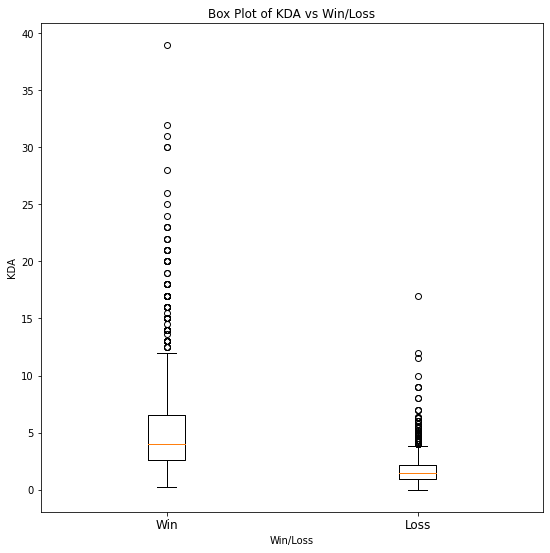

In [10]:
kda_win = []
kda_lose = []

for c, col in df.iterrows():
    if col['win'] == True:
        kda_win.append(col['kda'])
    else:
        kda_lose.append(col['kda'])
        
fig, ax = plt.subplots(figsize = (9,9))

ax.boxplot(x = [kda_win, kda_lose])
ax.set_xlabel("Win/Loss")
ax.set_xticks([1,2], labels = ['Win', 'Loss'])
ax.set_xticklabels(['Win', 'Loss'], fontsize=12)
ax.set_yticks(np.arange(0, 41, 5))
ax.set_ylabel("KDA")
ax.set_title("Box Plot of KDA vs Win/Loss")

This box plot explores the difference of KDA among winners and losers of a match. The line in the middle of each plot represents the median, and we can note that the median KDA of winners is around 4, whereas players who lose have a median KDA of around 2. This is a much more accurate representation of the data compared to using the means because of the severe number of outliers, giving a truer indication of KDA's based on winners and losers.

The disparity in KDA of winners and losers is what we expected. If you have many kills and assists, you obtain more gold, which allows players to buy items that make them stronger. Thus, giving players with a higher KDA an advantage during the match.

### Team Dragon Kills vs Win/Loss

Text(0.5, 1.0, 'Box Plot of Team Dragon Kills and Win/Loss')

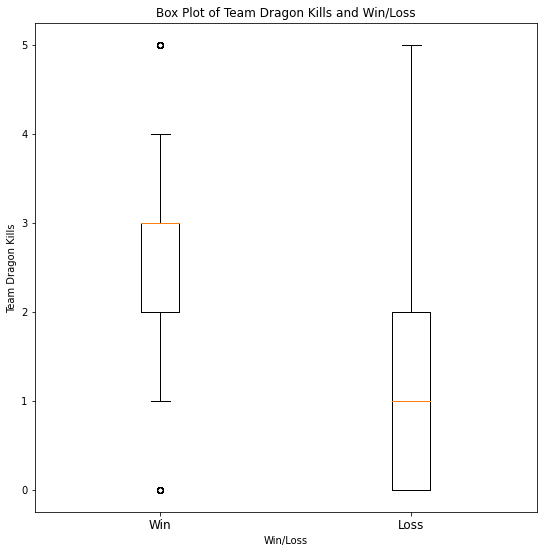

In [11]:
dragon_win = []
dragon_lose = []

for c, col in df.iterrows():
    if col['win'] == True:
        dragon_win.append(col['team_dragons'])
    else:
        dragon_lose.append(col['team_dragons'])
        
fig, ax = plt.subplots(figsize = (9,9))

ax.boxplot(x = [dragon_win, dragon_lose])
ax.set_xlabel("Win/Loss")
ax.set_xticks([1,2], labels = ['Win', 'Loss'])
ax.set_xticklabels(['Win', 'Loss'], fontsize=12)
ax.set_yticks(np.arange(0, 5.5, 1))
ax.set_ylabel("Team Dragon Kills")
ax.set_title("Box Plot of Team Dragon Kills and Win/Loss")

From this boxplot, we can see that the number of dragon's a team obtains impacts the outcome of a game. On average, game winners will get 3 dragons as a team, but losers will only get 1. Since dragons give everyone on the team a power up, people will generally prioritize killing dragons. One thing to note about dragon kills is the concept of snowballing. The term `snowballing` means that the team that is currently winning does something to further increase their lead. Teams can snowball their lead by killing neutral objectives like dragons. Since the team is already winning, securing the dragon should not be a problem and the dragon makes them even stronger.

### Multiple Variables vs Win/Loss

#### Vision vs KDA with Win/Loss

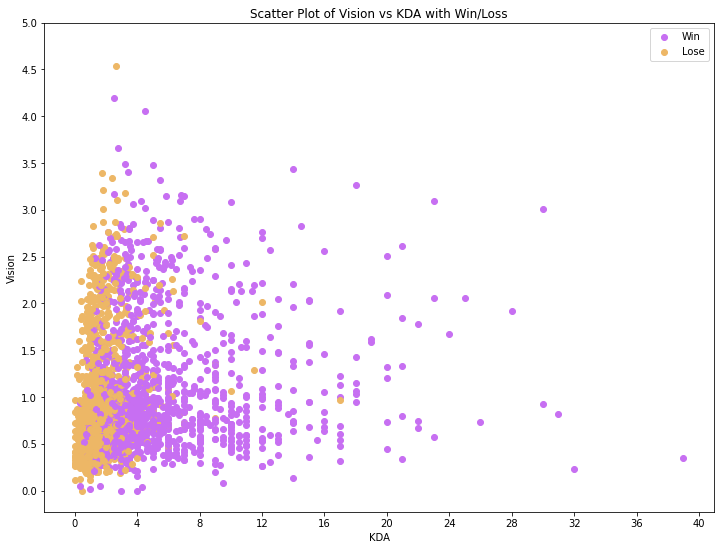

In [12]:
tCheck = True
fCheck = True

plt.figure(figsize=(12,9))

for index, row in df.iterrows():
    if row['win'] == True:
        if tCheck == True:
            plt.scatter(row['kda'], row['vision'], c = '#c76ff2', label = 'Win')
            tCheck = False
        else:
            plt.scatter(row['kda'], row['vision'], c = '#c76ff2')
    else:
        if fCheck == True:
            plt.scatter(row['kda'], row['vision'], c = '#edb766', label = 'Lose')
            fCheck = False
        else:
            plt.scatter(row['kda'], row['vision'], c = '#edb766')
    

plt.title("Scatter Plot of Vision vs KDA with Win/Loss")
plt.xlabel("KDA")
plt.ylabel("Vision")

plt.xticks(np.arange(0, 41, 4))
plt.yticks(np.arange(0, 5.5, 0.5))

plt.legend()
plt.show()

From this plot, it is quite clear that players that finish a match with a KDA less than 3 end up losing the match. Additionally, it doesn't seem like vision has much of an impact on the outcome of a match, since vision varies quite greatly among both winners and losers. We'll look at this more thorougly later with an SVM model.

#### Vision vs Team Dragons with Win/Loss

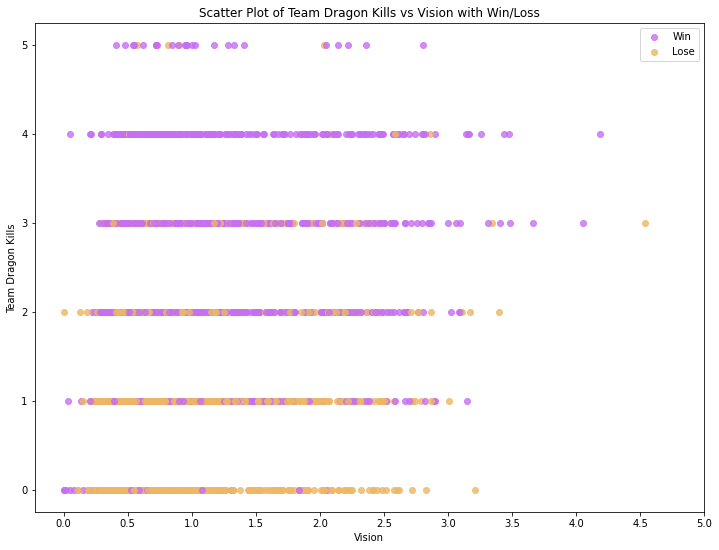

In [13]:
tCheck = True
fCheck = True

plt.figure(figsize=(12,9))

for index, row in df.iterrows():
    if row['win'] == True:
        if tCheck == True:
            plt.scatter(row['vision'], row['team_dragons'], c = '#c76ff2', label = 'Win', alpha = 0.8)
            tCheck = False
        else:
            plt.scatter(row['vision'], row['team_dragons'], c = '#c76ff2', alpha = 0.8)
    else:
        if fCheck == True:
            plt.scatter(row['vision'], row['team_dragons'], c = '#edb766', label = 'Lose', alpha = 0.8)
            fCheck = False
        else:
            plt.scatter(row['vision'], row['team_dragons'], c = '#edb766', alpha = 0.8)
    

plt.title("Scatter Plot of Team Dragon Kills vs Vision with Win/Loss")
plt.ylabel("Team Dragon Kills")
plt.xlabel("Vision")

plt.yticks(np.arange(0, 6, 1))
plt.xticks(np.arange(0, 5.5, 0.5))

plt.legend()
plt.show()

From this scatterplot, we can see the impact team dragon kills has on the outcome of a match. In matches where teams get 2 or more dragon kills, they generally tend to win the match. As stated earlier, killing a dragon gives a power up to everyone on the team. 

## Hypothesis Testing

When analyzing our data set, we want to test a hypothesis. A hypothesis is an educated guess that a data scientist can make about their data. Hypothesis testing allows data scientists to see if they have meaningful results. Hypothesis testing takes into account of the probability of a data scientist getting results by chance. If the results happened by chance, then the experiment is not repeatable and thus, useless. When hypothesis testing, we want to determine what hypothesis we want to test. In this tutorial, we hypothesis that having a higher KDA leads to a higher frequency of winning. When hypothesis testing, we will use our hypothesis to determine a null hypothesis. As data scientists, we want to show that we have enough data to effectively reject our null hypothesis. From our hypothesis, our null hypothesis would be: Having a higher KDA does not lead to a higher frequency of winning.

In [14]:
# Encoding loss and win as 0 and 1

hypothesis_df = df[['kda', 'win']].copy()
hypothesis_df = hypothesis_df.replace({'win' : {False : 0, True : 1} })

kda = [[i] for i in hypothesis_df['kda']]
p = f_regression(kda, hypothesis_df['win'])
print(p[1])

[1.05422361e-152]


We can use p-values to validate our hypothesis. A p-value is the probability that, assuming our null hypothesis is true, we get the results we observe. By using SKLearn's feature selection class, we can calculate the p-value of $8.5068 \times 10^{154}$. Usually, if we obtain a p-value that is less than 5%, we can confidentally reject our null hypothesis. So, we can conclude that having a higher KDA leads to a higher win percentage.

When hypothesis testing, there are a few things that you need to keep in mind. In order to keep analyzation unbiased, the hypothesis should be determined before looking at the data or performing any processing on the data. Additionally, there should be no tidying of the data that will bias the hypothesis. For example, not removing outliers will keep hypothesis testing as accurate as possible.

Now that you have seen an example of hypothesis testing, try coming up with your own hypotheses and respective null hypotheses and testing them yourself!

### Predicting Game Outcomes Using KDA

Now that we know that having a higher KDA leads to a player winning more, we can use different machine learning classification algorithms to create a model that can predict if a player won or loss based on their KDA. In this tutorial, we will use a Decision Tree Model. More information about decision trees can be found in the link below. 

In [15]:
# Decision Tree Model: https://scikit-learn.org/stable/modules/tree.html

DT_df = df[['kda', 'win']].copy()
DT_df = DT_df.replace({'win' : {False : 0, True : 1} })

X = DT_df.drop('win', axis=1)
Y = DT_df['win']

# Split up data into training data nd testing data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=0)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
predicted = dt.predict(X_test)
actual = np.array(y_test)
predictions = np.array(predicted)
print(metrics.confusion_matrix(actual, predictions))

[[311  73]
 [ 91 298]]


In order to use our model, we must first extract the data that we need from our original dataframe. Since we are only interested in KDA and win/loss, we will only focus on those two columns. Since Riot's API represents whether or not the player won using a boolean, we need to encode those values numerically because our machine learning algorithm does not understand categorical data. Thus, we encode a loss with the value $0$ and a win with the value $1$. 

When fitting our algorithm, we do not want to use our entire data set. This is because we want to use a portion of our data set to test how accurate our model was. So, we decided to use $70\%$ of our data to train the model, and $30\%$ of our data to test our model. After splitting our data, we can use SKLearn's DecisionTreeClassifier class to fit a model. Then, using the metrics class, we can create a confusion matrix using the actual outcomes and our model's outcomes to see how accurate our classification model was. 

The main diagonal of our confusion matrix tells us the number of accurately predicted values. From the matrix, we can see that our model successfully predicted $324+297=621$ outcomes of games. The other values in the matrix show the false negatives and false positives that our model failed to predict. We can calculate the accuracy of our model by adding up the values in the main diagonal and divide that by our test size: $$\frac{324+297}{324+86+108+297} = \frac{621}{815} = 76.2\%$$

From our exploratory analysis, we observed that there were many outliers for KDA. This could be one reason why our model was not as accurate as we wanted it to be. This also shows that having a high KDA does not automatically mean a player will win. This is evident because a player can perform exceptionally well and have a high KDA, but they could still lose if their teammates are performing exceptionally bad. From our hypothesis test, we know that a high KDA increases their chances of winning, but there are also other many different factors to winning a game. So, we can try and add another factor to our model. Hopefully, introducing another variable will help us better predict win/loss.

### What Happens When We Add Another Variable?

In the last section, we saw how a player's KDA could be used to predict the outcome of a game. However, we can fit a model using multiple variables as well. For this part, we will use SVM or a Support Vector Machine model to classify our data into wins and losses by using both KDA and vision. We chose a SVM model because it can visually classify observations by showing the boundaries of the different categories (wins and losses).

In [16]:
# SVM Model: https://scikit-learn.org/stable/modules/svm.html

SVM_df = df[['kda', 'vision', 'win']].copy()
SVM_df = SVM_df.replace({'win' : {False : 0, True : 1} })

xx, yy = np.meshgrid(np.linspace(0, SVM_df['kda'].max() , 500), np.linspace(0, SVM_df['vision'].max(), 500))

X = SVM_df.drop('win', axis=1)
Y = SVM_df['win']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=0)

clf = svm.NuSVC(gamma="auto")
clf.fit(X_train, y_train)

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but NuSVC was fitted with feature names
  warnings.warn(


As before, we will split our data set into two parts: training data and test data. Using SKLearn's SVM class, we can fit a model using our training data.

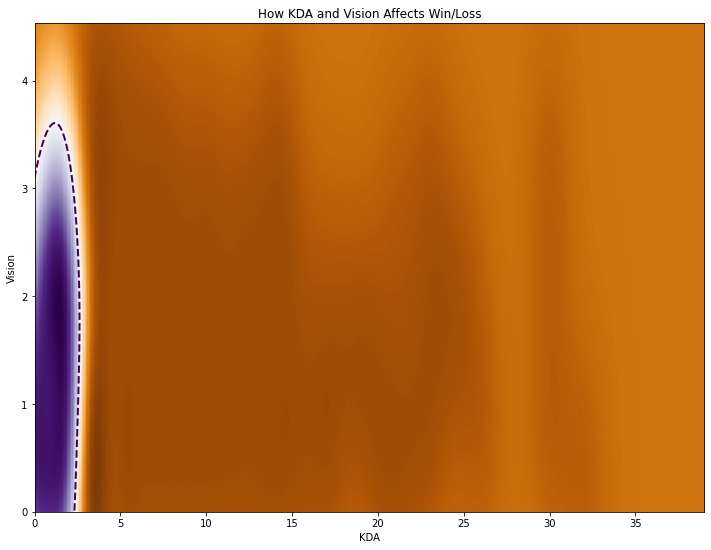

In [17]:
plt.figure(figsize = (12, 9))

plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    aspect="auto",
    origin="lower",
    cmap=plt.cm.PuOr_r,
)
contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2, linestyles="dashed")

plt.xticks()
plt.yticks()

plt.title('How KDA and Vision Affects Win/Loss')
plt.xlabel('KDA')
plt.ylabel('Vision')
plt.axis([0, SVM_df['kda'].max(), 0, SVM_df['vision'].max()])
plt.show()

We can visualize our data by plotting the divider of our SVM model. From the plot, we can see that our model will classify the game as a loss if the player has a KDA and vision score within the purple section. Conversely, our model will classify the game as a win if the player has a KDA and vision score outside of the purple section, inside of the orange section.

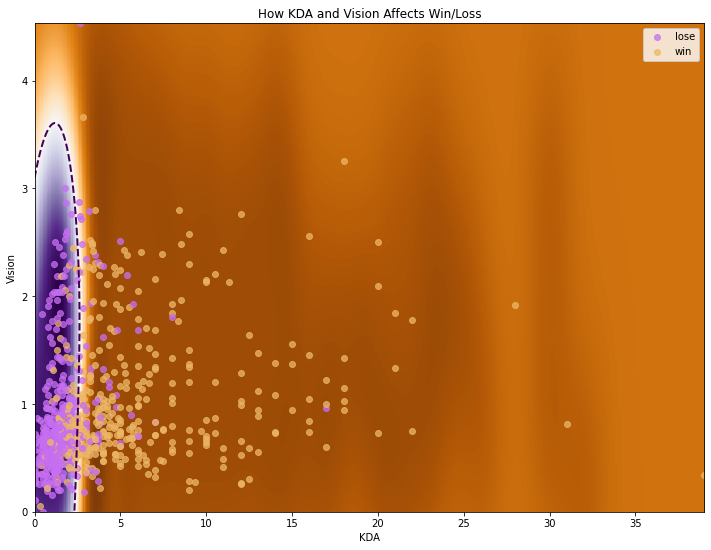

In [18]:
w_checked = False
l_checked = False

plt.figure(figsize = (12, 9))

plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    aspect="auto",
    origin="lower",
    cmap=plt.cm.PuOr_r,
)

contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2, linestyles="dashed")

for index, row in X_test.iterrows():
    if y_test[index] == 0:  
        if not l_checked:
            plt.scatter(row['kda'], row['vision'], c='#c76ff2', label='lose', alpha=0.75)
            l_checked = True
        else:
            plt.scatter(row['kda'], row['vision'], c='#c76ff2', alpha=0.75)
    else:
        if not w_checked:
            plt.scatter(row['kda'], row['vision'], c='#edb766', label='win', alpha=0.75)
            w_checked = True
        else:
            plt.scatter(row['kda'], row['vision'], c='#edb766', alpha=0.75)

plt.legend()
plt.xticks()
plt.yticks()

plt.title('How KDA and Vision Affects Win/Loss')
plt.xlabel('KDA')
plt.ylabel('Vision')
plt.axis([0, SVM_df['kda'].max(), 0, SVM_df['vision'].max()])
plt.show()

Using our contour plot, we can visually see how accurate our model was by only plotting the test points (and not the training points) into our graph. The plot shows wins as an orange point and losses as a purple point. We can observe that purple points in the purple region and orange points in the orange region were accurate predictions. On the other hand, purple points in the orange region and orange points in the purple region show inaccurate predictions. 

In [19]:
y_pred = clf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8033635187580854


We can numerically calculate the accuracy of our model by once again using SKLearn's metrics class. It looks like our new model has an accuracy of $78.9\%$ which is about $3\%$ more accurate than our previous model. From our explatory analysis, we saw that vision was not a large factor in determining a win or a loss. So, it makes sense that our accuracy didn't increase significantly.

We can continue to add variables to see if they affect our model. For fun, lets see how a team's dragons could change our model.

### How About A Third Variable?

In [20]:
DT_df = df[['kda', 'vision', 'team_dragons', 'win']].copy()
DT_df = DT_df.replace({'win' : {False : 0, True : 1} })

X = DT_df.drop('win', axis=1)
Y = DT_df['win']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=0)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
predicted = dt.predict(X_test)
actual = np.array(y_test)
predictions = np.array(predicted)
metrics.confusion_matrix(actual, predictions)

array([[309,  75],
       [ 93, 296]])

Using the same deicison tree model as before, we can apply this model with multiple variables. We can actually see that our model became more inaccurate: $$\frac{309+298}{309+101+107+298} = \frac{607}{815} = 74.48\%$$

This could be because we are using too many variables or too many non correlated variables in our model and have accidentally overfitted our model. Overfitting a model occurs when our model is too good at predicting a specific, limited number of points. This makes it so that our model becomes inaccurate when it comes to different data sets. 

## Conclusion

From our tutorial, we observed that win rate is largely affected by a player's KDA, slightly affected by a player's vision score, and not affected by the team's dragons.Even though League of Legends is a very complex game with many different variables determining a game's outcome, a motivated data scientist can analyze these variables using Riot's extensive API. A game analyst can pick games they are interested in (normal games, ranked games, professional games) and the variables they want to analyze. Then, they can create visuals, test hypotheses, and create machine learning models at their own discretion. The possibilities are endless.

Hopefully, we hope that the tutorial has given insight to how data science can be conducted. As seen with our examples, data science can pose many challenges from large, confusing API responses, to variables that have little to no effect in the studied outcome. However, with practice, data science can provide many useful insights to fields not confined to League of Legends but to all fields as well.